### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                              # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.collab import *                         # Getting all the Libraries.
from fastai.tabular.all import *                    # Getting all the Libraries.

### **GETTING THE DATASET:**
- I will use the subset of [**MovieLens**](https://grouplens.org/datasets/movielens/) dataset. The entire dataset contains tens of millions of movie rankings i.e a combination of a movie ID, a user ID and a numeric rating. 

In [5]:
#@ GETTING THE DATASET: 
path = untar_data(URLs.ML_100k)                     # Getting Path to the Dataset. 
path.ls()                                           # Inspecting the Dataset. 

(#23) [Path('/root/.fastai/data/ml-100k/ua.base'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/ub.base'),Path('/root/.fastai/data/ml-100k/u2.base'),Path('/root/.fastai/data/ml-100k/u.user')...]

In [6]:
#@ READING THE DATASET: 
ratings = pd.read_csv(path/"u.data", delimiter="\t", header=None, 
                      names=["user", "movie", "rating", "timestamp"])   # Reading the Dataset. 
ratings.head()                                                          # Inspecting the Dataset. 

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
#@ INSPECTING THE COMBINATIONS: EXAMPLE: 
last_skywalker = np.array([0.98, 0.9, -0.9])                            # Initialization. 
user1 = np.array([0.9, 0.8, -0.6])                                      # Initialization. 
(user1*last_skywalker).sum()                                            # Getting Dot Product.  

2.1420000000000003

**Dot Product:**
- The mathematical operation of multiplying the elements of two vectors together and then summing up the result is called **Dot Product**. 

### **CREATING DATALOADERS:**

In [8]:
#@ READING THE DATASET: MOVIE TITLES: 
movies = pd.read_csv(path/"u.item", delimiter="|", encoding="latin-1", 
                     usecols=(0, 1), names=("movie", "title"), 
                     header=None)                                       # Reading the Dataset. 
movies.head()                                                           # Inspecting the Dataset. 

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
#@ MERGING THE DATAFRAMES: 
ratings = ratings.merge(movies)                                         # Merging the DataFrames. 
ratings.head()                                                          # Inspecting the DataFrame. 

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [10]:
#@ CREATING DATALOADERS: 
dls = CollabDataLoaders.from_df(ratings, item_name="title", bs=64)       # Initializing DataLoaders. 
dls.show_batch()                                                         # Inspecting the Batches. 

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [11]:
#@ CONVERTING INTO MATRICES: 
n_users = len(dls.classes["user"])                            # Getting Number of Users. 
n_movies = len(dls.classes["title"])                          # Getting Number of Movies. 
n_factors = 5                                                 # Initializing Latent Factors. 
user_factors = torch.randn(n_users, n_factors)                # Initializing User Factors. 
movie_factors = torch.randn(n_movies, n_factors)              # Initializing Movie Factors. 

In [12]:
#@ IMPLEMENTATION OF ONE HOT VECTORS: 
one_hot_3 = one_hot(3, n_users).float()                       # Initializing One Hot Vectors. 
user_factors.t() @ one_hot_3                                  # Initializing Dot Product.
user_factors[3]                                               # Inspecting One Hot Vectors.  

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

**Embedding:**
- The special layer that indexes into a vector using an integer but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one hot encoded vector is called **Embedding**. Multiplying by a one hot encoded matrix using the computational shortcut that it can be implemented by simply indexing directly. The thing that multiply the one hot encoded matrix is called the **Embedding Matrix**. 

### **COLLABORATIVE FILTERING**

In [13]:
#@ EXAMPLE OF A CLASS: 
class Example:                                 # Defining Class. 
    def __init__(self, a):                     # Constructor Function. 
        self.a = a                             # Initialization. 
    def say(self, x):                          # Defining Function. 
        return f"Hello {self.a}, {x}"
#@ IMPLEMENTATION OF CLASS: 
ex = Example("Thinam")                         # Initialization. 
ex.say("how are you?")                         # Implementation. 

'Hello Thinam, how are you?'

In [14]:
#@ EXAMPLE OF A CLASS WITH PYTORCH MODULE: 
class DotProduct(Module):                                           # Defining Class. 
    def __init__(self, n_users, n_movies, n_factors):               # Constructor Function. 
        self.user_factors = Embedding(n_users, n_factors)           # Initialization. 
        self.movie_factors = Embedding(n_movies, n_factors)         # initialization. 
    
    def forward(self, x):                                           # Forward Propagation Function. 
        users = self.user_factors(x[:, 0])                          # Implementation. 
        movies = self.movie_factors(x[:, 1])                        # Implementation. 
        return (users * movies).sum(dim=1)                          # Matrix Multiplication. 

**Note:**
- The input of the model is a tensor of shape batch_size X 2 where the first column contains the user IDs and the second column contains the movie IDs. 

In [15]:
#@ GETTING A BATCH:
x, y = dls.one_batch()                                 # Getting a Batch. 
x.shape                                                # Inspecting the Shape. 

torch.Size([64, 2])

In [16]:
#@ TRAINING SIMPLE MODEL FROM SCRATCH: 
model = DotProduct(n_users, n_movies, 50)              # Initializing the Class. 
learn = Learner(dls, model, loss_func=MSELossFlat())   # Initializing the Learner. 
learn.fit_one_cycle(5, 5e-3)                           # Training the Model. 

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:07
1,1.093331,1.109981,00:07
2,0.958258,0.990199,00:07
3,0.814234,0.894916,00:07
4,0.780714,0.882022,00:07


In [17]:
#@ DEFINING THE DOT PRODUCT CLASS WITH RANGE: 
class DotProduct(Module):                                               # Defining Class.
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)): # Constructor Function. 
        self.user_factors = Embedding(n_users, n_factors)               # Initialization.
        self.movie_factors = Embedding(n_movies, n_factors)             # Initialization. 
        self.y_range = y_range                                          # Initialization. 

    def forward(self, x):                                               # Forward Propagation Function. 
        users = self.user_factors(x[:, 0])                              # Implementation. 
        movies = self.movie_factors(x[:, 1])                            # Implementation. 
        return sigmoid_range((users*movies).sum(dim=1), *self.y_range)  # Matrix Multiplication and Range. 

#@ TRAINING SIMPLE MODEL FROM SCRATCH: 
model = DotProduct(n_users, n_movies, 50)                               # Initializing the Class. 
learn = Learner(dls, model, loss_func=MSELossFlat())                    # Initializing the Learner. 
learn.fit_one_cycle(5, 5e-3)                                            # Training the Model. 

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:07
1,0.878134,0.918898,00:07
2,0.675850,0.875467,00:07
3,0.483372,0.877939,00:07
4,0.378927,0.881887,00:07


In [18]:
#@ DEFINING THE DOT PRODUCT CLASS WITH BIASES: 
class DotProductBias(Module):                                            # Defining Class.
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):  # Constructor Function.
        self.user_factors = Embedding(n_users, n_factors)                # Initialization. 
        self.user_bias = Embedding(n_users, 1)                           # Initialization. 
        self.movie_factors = Embedding(n_movies, n_factors)              # Initialization. 
        self.movie_bias = Embedding(n_movies, 1)                         # Initialization. 
        self.y_range = y_range                                           # Initialization. 
    
    def forward(self, x):                                                # Forward Propagation Function. 
        users = self.user_factors(x[:, 0])                               # Implementation. 
        movies = self.movie_factors(x[:, 1])                             # Implementation. 
        res = (users * movies).sum(dim=1, keepdim=True)                  # Matrix Multiplication. 
        res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])        # Adding Bias. 
        return sigmoid_range(res, *self.y_range)                         # Sigmoid Range. 

#@ TRAINING SIMPLE MODEL FROM SCRATCH: 
model = DotProductBias(n_users, n_movies, 50)                           # Initializing the Class. 
learn = Learner(dls, model, loss_func=MSELossFlat())                    # Initializing the Learner. 
learn.fit_one_cycle(5, 5e-3)                                            # Training the Model. 

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:08
1,0.846664,0.865633,00:08
2,0.608090,0.865127,00:08
3,0.413482,0.887318,00:08
4,0.286971,0.894876,00:08


**WEIGHT DECAY REGULARIZATION:**
- **Weight Decay** consists of adding sum of the squared weights to the loss function. The idea is that the larger the coefficients are, the sharper the canyons will be in the loss function. 

In [19]:
#@ WEIGHT DECAY REGULARIZATION: SIMPLE CONCEPT: 
# loss_with_wd = loss + wd * (parameters**2).sum()                # Initializing Loss with WD. 
# parameters.grad += wd * 2 * parameters                          # Initializing Derivative. 

In [20]:
#@ TRAINING THE MODEL WITH WEIGHT DECAY REGULARIZATION: 
model = DotProductBias(n_users, n_movies, 50)                     # Initializing the Model. 
learn = Learner(dls, model, loss_func=MSELossFlat())              # Initializing the Learner. 
learn.fit_one_cycle(5, 5e-3, wd=0.1)                              # Training the Model. 

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:08
1,0.888625,0.882614,00:08
2,0.771066,0.832743,00:08
3,0.599807,0.822374,00:08
4,0.504981,0.822528,00:08


**CREATING EMBEDDING MODULE:**

In [21]:
#@ EXAMPLE CLASS WITHOUT PARAMETER MODULE:
class T(Module):                                                 # Defining Class. 
    def __init__(self):                                          # Constructor Function. 
        self.a = torch.ones(3)                                   # Initializing Tensor. 
#@ IMPLEMENTATION: 
L(T().parameters())                                              # Getting Parameters. 

(#0) []

In [22]:
#@ EXAMPLE CLASS WITH PARAMETER MODULE:
class T(Module):                                                 # Defining Class. 
    def __init__(self):                                          # Constructor Function. 
        self.a = nn.Parameter(torch.ones(3))                     # Initializing Tensor. 
#@ IMPLEMENTATION: 
L(T().parameters())                                              # Getting Parameters. 

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [23]:
#@ EXAMPLE CLASS WITH PARAMETER MODULE:
class T(Module):                                                 # Defining Class. 
    def __init__(self):                                          # Constructor Function. 
        self.a = nn.Linear(1, 3, bias=False)                     # Initializing Tensor. 
#@ IMPLEMENTATION: 
t = T()                                                          # Initialization. 
L(t.parameters())                                                # Getting Parameters. 
type(t.a.weight)                                                 # Inspection. 

torch.nn.parameter.Parameter

In [24]:
#@ FUNCTION TO CREATE TENSOR AS PARAMETER: 
def create_params(size):                                                # Defining Function. 
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))            # Initializing Parameter. 

#@ DEFINING THE DOT PRODUCT CLASS WITHOUT EMBEDDING: 
class DotProductBias(Module):                                           # Defining Class. 
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):  # Constructor Function. 
        self.user_factors = create_params([n_users, n_factors])         # Initialization. 
        self.user_bias = create_params([n_users])                       # initialization. 
        self.movie_factors = create_params([n_movies, n_factors])       # Initialization. 
        self.movie_bias = create_params([n_movies])                     # Initialization. 
        self.y_range = y_range                                          # Initialization. 
    
    def forward(self, x):                                               # Forward Propagation Function. 
        users = self.user_factors[x[:, 0]]                              # Implementation. 
        movies = self.movie_factors[x[:, 1]]                            # Implementation. 
        res = (users * movies).sum(dim=1)                               # Matrix Multiplication. 
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]       # Adding Bias. 
        return sigmoid_range(res, *self.y_range)                        # Sigmoid Range. 

#@ TRAINING SIMPLE MODEL FROM SCRATCH: 
model = DotProductBias(n_users, n_movies, 50)                           # Initializing the Class. 
learn = Learner(dls, model, loss_func=MSELossFlat())                    # Initializing the Learner. 
learn.fit_one_cycle(5, 5e-3, wd=0.1)                                    # Training the Model. 

epoch,train_loss,valid_loss,time
0,0.929254,0.953444,00:08
1,0.865246,0.878304,00:09
2,0.720294,0.838921,00:09
3,0.582796,0.829129,00:09
4,0.474043,0.829031,00:08


**INTERPRETATING EMBEDDINGS AND BIASES:**

In [25]:
#@ GETTING LOWEST BIASES MOVIES: 
movie_bias = learn.model.movie_bias.squeeze()               # Getting Movie Biases. 
idxs = movie_bias.argsort()[:5]                             # Sorting. 
[dls.classes["title"][i] for i in idxs]                     # Getting Movies. 

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Amityville 3-D (1983)',
 'Beautician and the Beast, The (1997)']

In [26]:
#@ GETTING HIGHEST BIASES MOVIES: 
idxs = movie_bias.argsort(descending=True)[:5]              # Getting Indexes. 
[dls.classes["title"][i] for i in idxs]                     # Getting Movies. 

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

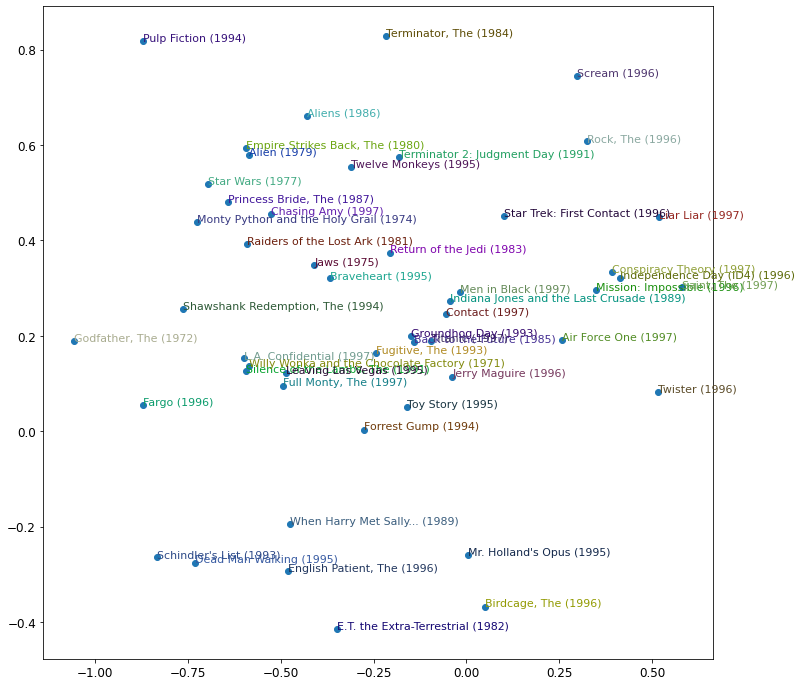

In [27]:
#@ REPRESENTATION OF MOVIES BASED ON PCA: 
g = ratings.groupby("title")["rating"].count()                      # Getting Counts of Ratings. 
top_movies = g.sort_values(ascending=False).index.values[:1000]     # Initializing Sorting. 
top_idxs = tensor([learn.dls.classes["title"].o2i[m] for m in \
                   top_movies])                                     # Getting Indexes. 
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)                                          # Getting PCA Components. 
fac0, fac1, fac2 = movie_pca.t()                                    # Getting PCA Factors. 
idxs = list(range(50))
X, Y = fac0[idxs], fac2[idxs]
plt.figure(figsize=(12, 12))
plt.scatter(X, Y)                                                   # Getting Scatter Plots. 
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### **COLLABORATIVE FILTERING USING FASTAI:**
- I will create and train **Collaborative Filtering** model using **Fastai** collab learner. 

In [28]:
#@ IMPLEMENTATION OF COLLAB LEARNER: 
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))  # Initializing the Learner. 
learn.fit_one_cycle(5, 5e-3, wd=0.1)                         # Training the Learner. 

epoch,train_loss,valid_loss,time
0,0.939464,0.954959,00:08
1,0.841215,0.876151,00:08
2,0.724404,0.832099,00:08
3,0.597228,0.816953,00:08
4,0.481373,0.817286,00:08


In [29]:
#@ INSPECTING LAYERS OF LEARNER: 
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [30]:
#@ GETTING MOVIES WITH HIGHEST BIASES:
movie_bias = learn.model.i_bias.weight.squeeze()        # Getting Biases. 
idxs = movie_bias.argsort(descending=True)[:5]          # Getting Indexes. 
[dls.classes["title"][i] for i in idxs]                 # Getting Movies. 

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

**EMBEDDING DISTANCE:**

In [31]:
#@ INITIALIZING MOVIE SIMILARITY WITH EMBEDDING DISTANCE: 
movie_factors = learn.model.i_weight.weight                         # Getting Movie Factors. 
idx = dls.classes["title"].o2i["Titanic (1997)"]                    # Getting Index. 
distances = nn.CosineSimilarity(dim=1)(movie_factors,
                                       movie_factors[idx][None])    # Getting Distances. 
idx = distances.argsort(descending=True)[1]                         # Getting Index. 
dls.classes["title"][idx]                                           # Getting Movie. 

'Forrest Gump (1994)'

### **DEEP LEARNING FOR COLLABORATIVE FILTERING:**

In [32]:
#@ GETTING OPTIMAL EMBEDDING MATRICES: 
embs = get_emb_sz(dls)                                              # Getting Embeddings. 
embs                                                                # Inspecting Embeddings. 

[(944, 74), (1665, 102)]

In [35]:
#@ IMPLEMENTATION OF CLASS: 
class CollabNN(Module):                                             # Defining Class. 
    def __init__(self,user_sz,item_sz,y_range=(0,5.5),n_act=100):   # Constructor Function. 
        self.user_factors = Embedding(*user_sz)                     # Initializing User Factors. 
        self.item_factors = Embedding(*item_sz)                     # Initializing Item Factors. 
        self.layers = nn.Sequential(                                # Initializing Sequential Module. 
            nn.Linear(user_sz[1] + item_sz[1], n_act),              # Initializing Linear Layer. 
            nn.ReLU(),                                              # Initializing Nonlinear Function. 
            nn.Linear(n_act, 1))                                    # Initializing Linear Layer. 
        self.y_range = y_range                                      # Initilization. 
    
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])  # Initializing Embedding Matrices. 
        x = self.layers(torch.cat(embs, dim=1))                     # Implementation. 
        return sigmoid_range(x, *self.y_range)                      # Implementation of Sigmoid Range. 

#@ CREATING THE MODEL: 
model = CollabNN(*embs)                                             # Initializing the Model. 

In [36]:
#@ TRAINING THE LEARNER: 
learn = Learner(dls, model, loss_func=MSELossFlat())                # Initializing the Learner. 
learn.fit_one_cycle(5, 5e-3, wd=0.1)                                # Training the Learner. 

epoch,train_loss,valid_loss,time
0,0.972395,0.944805,00:08
1,0.897500,0.924535,00:08
2,0.870171,0.903539,00:08
3,0.820569,0.872207,00:09
4,0.800743,0.872517,00:08


In [37]:
#@ TRAINING THE COLLAB LEARNER USING FASTAI: 
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), 
                       layers=[100, 50])                             # Initializing Collabe Learner. 
learn.fit_one_cycle(10, 5e-3, wd=0.1)                                # Training the Learner. 

epoch,train_loss,valid_loss,time
0,0.936648,1.008914,00:09
1,0.940208,0.947857,00:09
2,0.894755,0.909129,00:09
3,0.906522,0.882600,00:10
4,0.851609,0.871867,00:10
5,0.809281,0.860921,00:10
6,0.805595,0.847570,00:10
7,0.744586,0.852434,00:10
8,0.705427,0.865453,00:10
9,0.650853,0.879485,00:09


In [38]:
#@ INSPECTING EMBEDDING NN:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, 
                         **kwargs)

**Note:**
- **EmbeddingNN** includes **kwargs** as a parameter to __init__. In Python **kwargs** in a parameter list means "put any additional keyword arguments into a dict called
kwargs." And **kwargs** in an argument list means "insert all key and value pairs in the kwargs dict as named arguments here."